## Sentence Quality Classification

Classifiy sentences into high / low quality. This is used to improve data quality for texts from different sources (scanned PDFs, crawled HTML, parsed Wikipedia, ..). It's mainly used to filter out artifacts from faulty parsing, HTML fragments, navigation elements, non-sentences (references, titles, ..)

In [303]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import load_config
import json
import nltk

### define a new configuration
config_dict = {
    # training data
    "train_file": "data/sentence-quality.csv",
     
    # model
   
    # chose tokenizer. possible values: "nst" and "sgt"
    ## NonStemmingTokenizer: 'nst'
    # - no stemming, only remove punctuation marks
    # - lowercase letters

    ## SimpleGermanTokenizer: 'sgt'
    # - remove punctuation marks
    # - stemming
    # - lowercase letters
    "tokenizer": "nst",
    
    # where to store the configuration file
    "config_path": "data/configuration-sentence-quality-classifier.json"
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [304]:
### save config file (don't change)
config_src = config_dict["config_path"]

with open(config_src, 'w+') as f:
    json.dump(config_dict, f, indent=4)
    
# load config object based on config file (don't change)
config = load_config.Configuration(config_src, True)

In [305]:
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(config_dict['tokenizer'])

In [306]:
# load training data
import pandas as pd 

data = pd.read_csv(config['train_file']) 
data = data.sample(frac=1).reset_index(drop=True)

,Satz,Tokens,Klassierung,Bemerkungen,label
0,Tod 10 Tage nach der Operation.,"['tod', '10', 'tage', 'nach', 'der', 'operation']",SENTENCE,NaN,SENTENCE
1,Decker: [http://kobra.bibliothek.uni-kassel.de...,"['decker', 'http', '', '', 'kobrabibliothekuni...",LOW_QUALITY,NaN,LOW_QUALITY
2,Matched-Pair-Vergleichsanalyse der roboterassi...,"['matched-pair-vergleichsanalyse', 'der', 'rob...",LOW_QUALITY,NaN,LOW_QUALITY
3,365 bildung an den Seiten umgebende Saum best...,"['365', 'bildung', 'an', 'den', 'seiten', 'umg...",LOW_QUALITY,NaN,LOW_QUALITY
4,1973 bis 1974 war er Assistenzarzt in der Abte...,"['1973', 'bis', '1974', 'war', 'er', 'assisten...",SENTENCE,NaN,SENTENCE


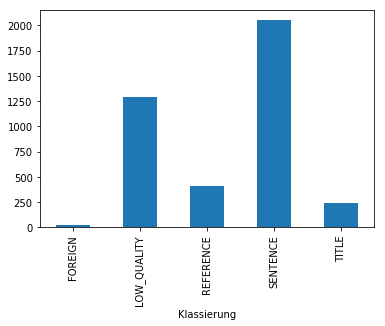

In [307]:
# set targets

data.groupby('Klassierung').Klassierung.count().plot.bar()

#data['label'] = pd.Series(['high' if a else 'low' for a in data['Klassierung'].isin(['SENTENCE'])], index=data.index)
data['label'] = pd.Series(data['Klassierung'], index=data.index)

# set label / classes
classes = list(data['label'].unique())
data.head()

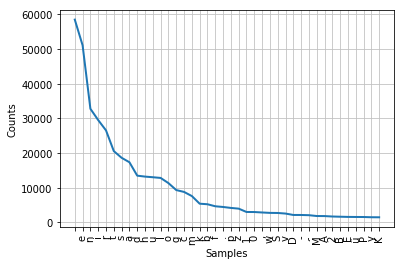

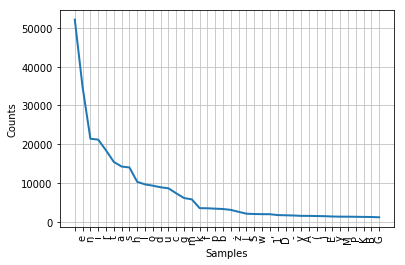

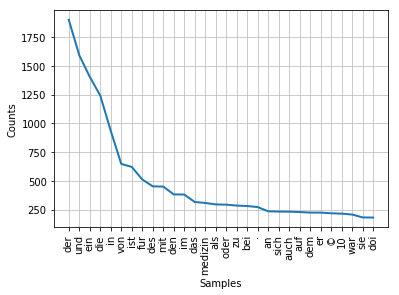

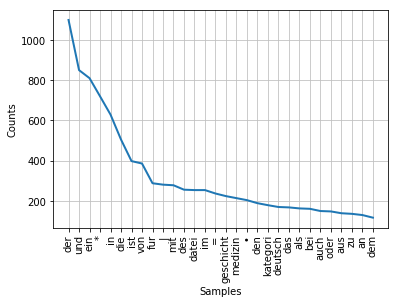

In [202]:
# character frequency analysis

high_quality = data.loc[data['Klassierung'].isin(['SENTENCE', 'REFERENCE'])]
low_quality = data.loc[[not a for a in data['Klassierung'].isin(['SENTENCE', 'REFERENCE'])]]

fdc = nltk.FreqDist()
tokens_h = []
for s in high_quality['Satz']:
    tokens_h.extend(tokenizer.tokenize(s))
    fdc.update(s)
    
# character frequencies
fdc.plot(40,cumulative=False)

tokens_l = []
fdc2 = nltk.FreqDist()
for s in low_quality['Satz']:
    tokens_l.extend(tokenizer.tokenize(s))
    fdc2.update(s)
    fdc.update(s)
    
# character frequencies
fdc2.plot(40,cumulative=False)

# word frequencies
fd = nltk.FreqDist(tokens_h)
fd.plot(30,cumulative=False) 
fd = nltk.FreqDist(tokens_l)
fd.plot(30,cumulative=False) 

In [323]:
# set input data

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=8, norm='l2', encoding='utf8', ngram_range=(2, 2), stop_words='english')
tfidf = tfidf.fit(data.Satz)

fd = nltk.FreqDist(tokens_h + tokens_l)

voc_chars = list(fdc.keys())[:200]
voc_words = list(fd.keys())[:500]

def convert_sentence_to_input(s):
    tokens = tokenizer.tokenize(s)
    fd_words = nltk.FreqDist(tokens)
    fd_chars = nltk.FreqDist(s)
    
    words = [fd_words.freq(w) for w in voc_words]
    chars = [fd_chars.freq(c) for c in voc_chars]
    
    words_in_vocab = sum(1 for i in words if i > 0.0)
    long_tail = float(words_in_vocab) /  len(tokens)
    
    tfidf_features = list(tfidf.transform([s]).toarray()[0])
    
    return np.array(words + chars + [long_tail/10.0], dtype=np.float32)

data['input'] = pd.Series([[convert_sentence_to_input(s)] for s in data['Satz']], index=data.index)
data.head()

,Satz,Tokens,Klassierung,Bemerkungen,label,input
0,Tod 10 Tage nach der Operation.,"['tod', '10', 'tage', 'nach', 'der', 'operation']",SENTENCE,NaN,SENTENCE,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16..."
1,Decker: [http://kobra.bibliothek.uni-kassel.de...,"['decker', 'http', '', '', 'kobrabibliothekuni...",LOW_QUALITY,NaN,LOW_QUALITY,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,Matched-Pair-Vergleichsanalyse der roboterassi...,"['matched-pair-vergleichsanalyse', 'der', 'rob...",LOW_QUALITY,NaN,LOW_QUALITY,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,365 bildung an den Seiten umgebende Saum best...,"['365', 'bildung', 'an', 'den', 'seiten', 'umg...",LOW_QUALITY,NaN,LOW_QUALITY,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1973 bis 1974 war er Assistenzarzt in der Abte...,"['1973', 'bis', '1974', 'war', 'er', 'assisten...",SENTENCE,NaN,SENTENCE,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [324]:
# fit a model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

models = [
    RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0),
    LinearSVC(),
    # MultinomialNB(),
    LogisticRegression(random_state=0),
    SVC(kernel='linear', gamma=2),
    # SVC(kernel='poly', gamma=2),
    SVC(kernel='rbf', gamma=2),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32, 16), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32, 16, 8), random_state=1)
]

X_train, X_test, y_train, y_test = train_test_split(np.array([e[0] for e in data['input']]), data['label'], random_state = 2)

print(X_train.shape)

# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

models = [model.fit(X_train, y_train) for model in models]


(3003, 701)


RandomForestClassifier: 0.705294705295
LinearSVC: 0.711288711289
LogisticRegression: 0.635364635365
SVC: 0.653346653347
SVC: 0.708291708292
MLPClassifier: 0.749250749251
MLPClassifier: 0.759240759241
MLPClassifier: 0.755244755245
MLPClassifier: 0.765234765235
MLPClassifier: 0.737262737263


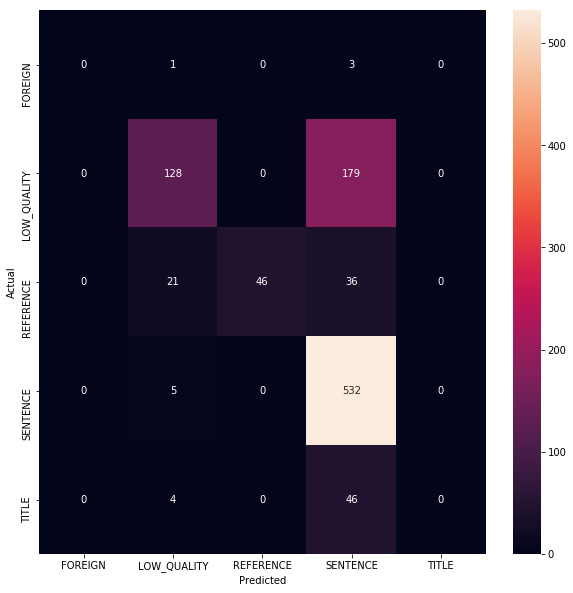

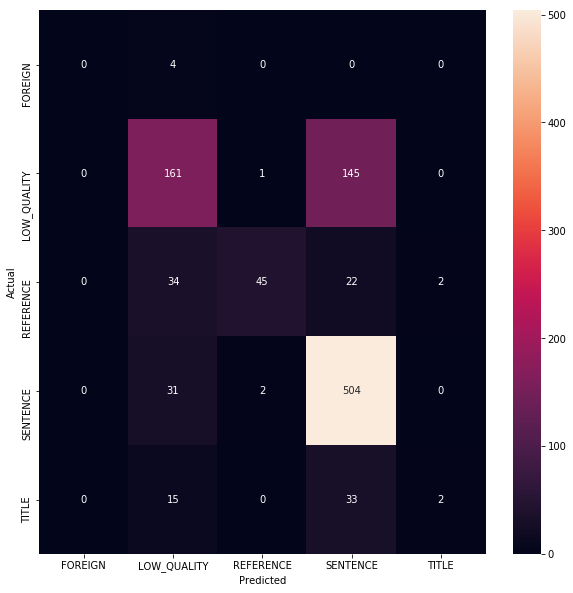

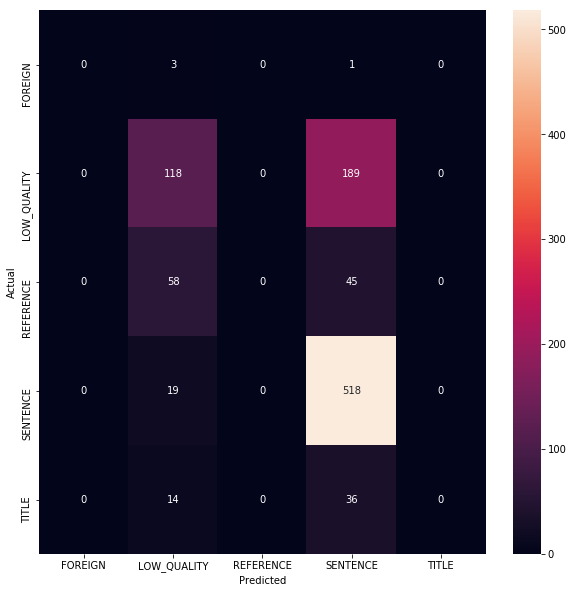

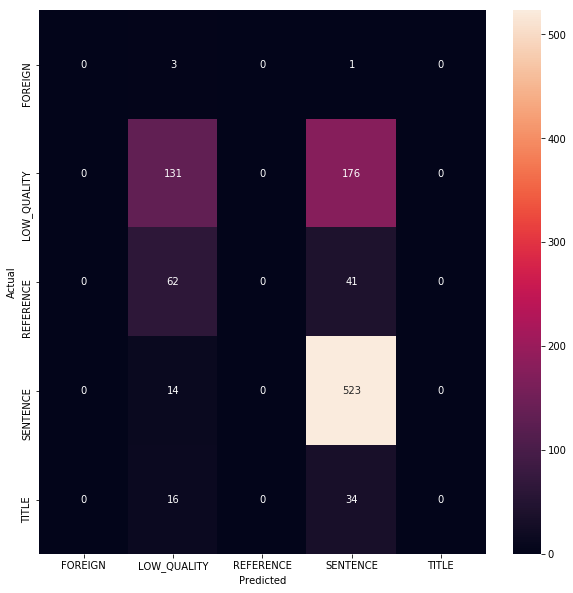

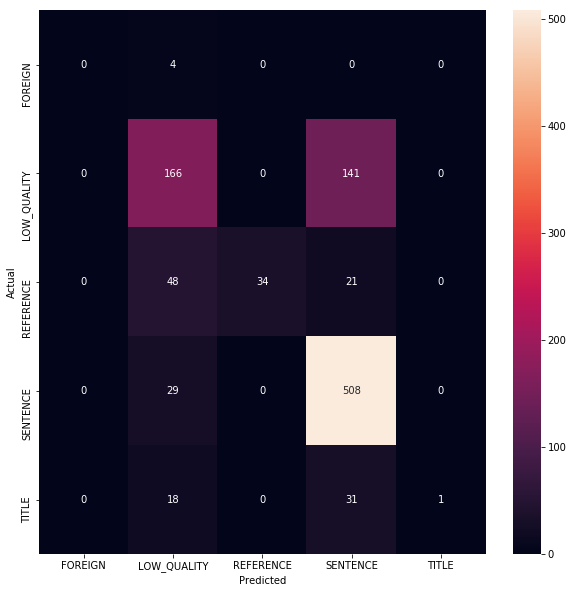

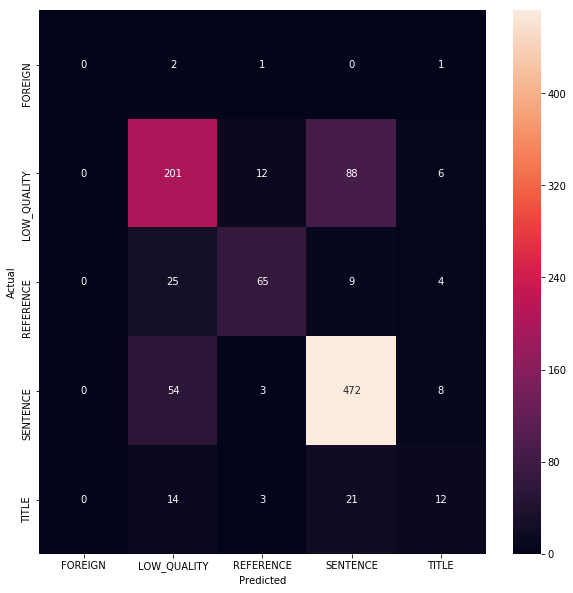

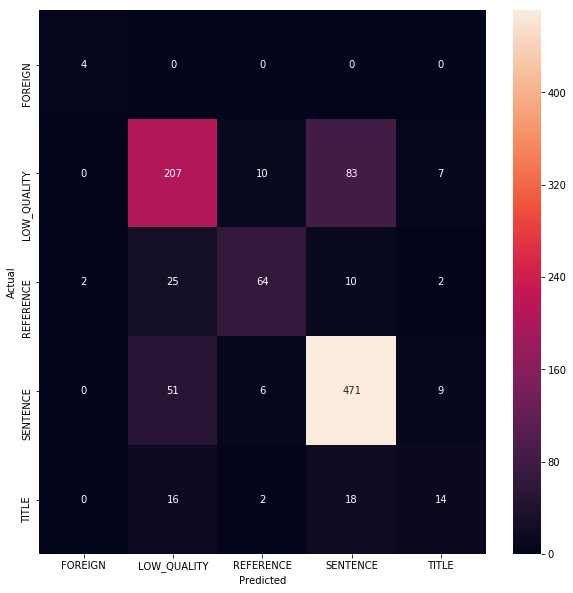

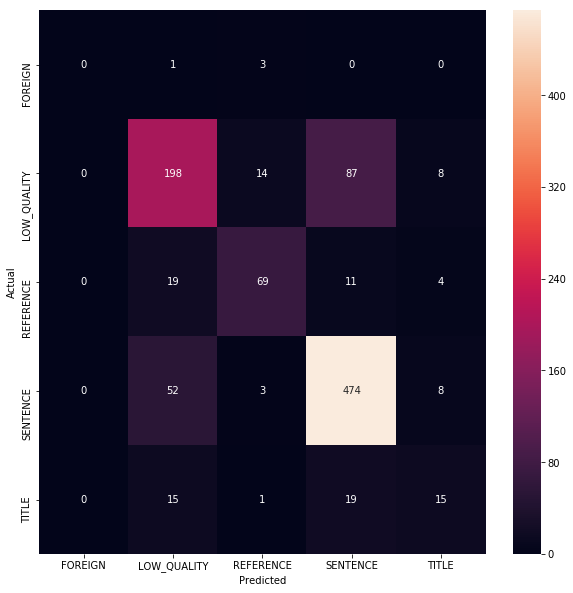

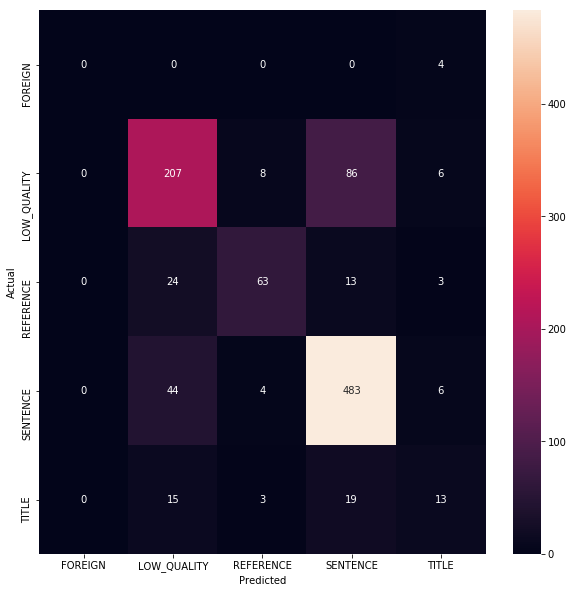

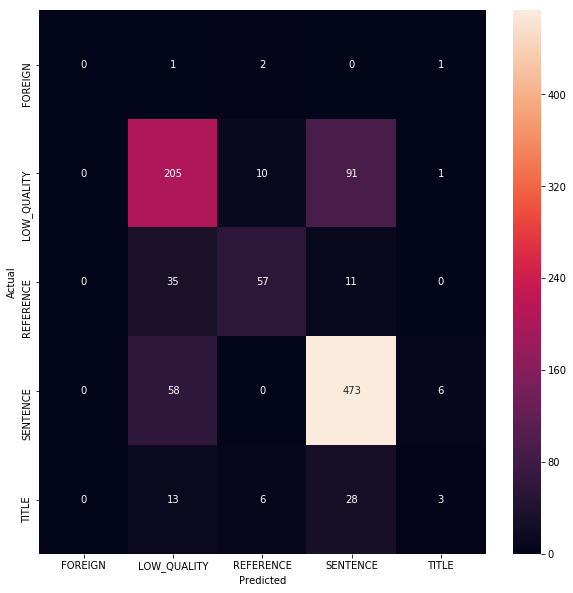

In [325]:
# model evaluation

for model in models:
    y_pred = model.predict(X_test)
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score

    print(model.__class__.__name__ + ": " + str(accuracy_score(y_test, y_pred)))

    conf_mat = confusion_matrix(y_test, y_pred)

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # plt.show()